In [50]:
import nltk
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import *
from pylab import *

import seaborn as sns # poista?
from scipy import stats as sts # zipf, linreg, powerlaw
from scipy.stats import t

### Resources:
1. https://www.nltk.org/book/
2. https://finnaarupnielsen.wordpress.com/2013/10/22/zipf-plot-for-word-counts-in-brown-corpus/


Read data and save important information for future.

In [146]:
files = ["flatland.txt", "panama-canal.txt"]
books = []

# Read data and save books to dict
for f in files:
    file = open(f, "r", encoding='utf-8')
    book = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(book)
    file.close()

books = {'flatland.txt': books[0], 'panama-canal.txt': books[1]}

# Tokenize and count frequencies
tokens = {}
counts = {}
ranks = {}
freqs = {}

for b in books:
    tokens_w_count = Counter(map(str.lower, books[b]))
    tokens[b] = sorted([k for k in tokens_w_count.keys()])
    counts[b] = np.array([tokens_w_count[k] for k in tokens[b]])
    ranks[b] = np.arange(1, len(counts[b]) + 1)
    indices = np.argsort(-counts[b])
    freqs[b] = counts[b][indices]


Define functions for finding specific information (for troubleshooting):

In [159]:
def getfreq(word, book):
    try:
        i = list(tokens[book]).index(word, 0, len(tokens[book]))
    except ValueError:
        print("Word not found.")
    else:
        print("Word: ", word)
        print("Freq: ", counts[book][i])
        #print("Rank: ", ranks[book][i])

# def getrank():

In [160]:
getfreq("the", "flatland.txt")

Word:  the
Freq:  2189


### Task 1.

Use appropriate NLTK coding (you can inspire from coding examples of the online NLTK book) in order to **plot the histogram of the twenty most frequent words** in each of the three ebooks. **Comment on the nature of these words** in terms of their relevance to the content of the ebook. Suggest your own approach to evaluate such relevancy.  

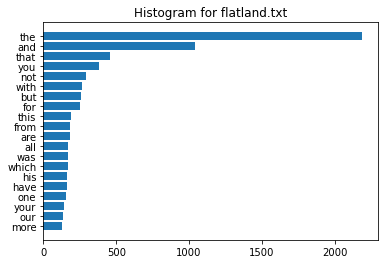

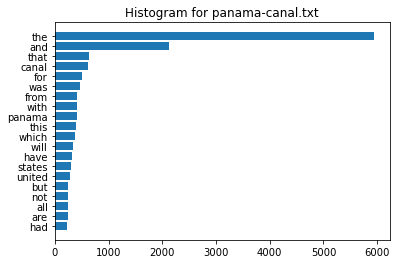

In [144]:
for b in books:
    df = pd.DataFrame({'word': tokens[b], 'count': counts[b]}).sort_values(by=['count'], ascending=False).head(20)
    df = df.sort_values(by=['count']) # ascending for plot
    
    # Histogram of 20 most freq
    x = list(df.loc[:, 'word'])
    y = list(df.loc[:, 'count'])
    
    title("Histogram for " + b)
    plt.barh(x, y)
    plt.show() 

### Task 2.

Use the frequency of the words to fit the Zipf distribution for each ebook. Draw the zipf fitting cure for each ebook and comment on the goodness of fit.

First define functions for fitting **linear regression**.

In [39]:
def linreg(ranks, frequencies, ci_level):
    r = log(ranks)
    fr = log(frequencies)

    slope, intercept, r_value, p_value, std_err = sts.linregress(r, fr)
    r_squared = r_value ** 2
    print("For the full data, we get the following linear regression")
    print("slope:     %f    intercept: %f" % (slope, intercept))
    print("r_value:   %f    p_value: %f" % (r_value, p_value))
    print("std_error: %f" % std_err)

    obs_values = fr
    fitted_value = slope * r + intercept
    residuals = obs_values - fitted_value

    n = len(fr)
    sse = sum(residuals ** 2)
    mse = sse / (n - 2)
    t_val = t.ppf(ci_level, n - 2)  # Student's t-distribution with n-2 df.
    S = sqrt(mse)
    SSX = sum((r - mean(r)) ** 2)

    SE_fit = S * sqrt(1 / n + (r - mean(r)) ** 2 / SSX)     # Standard error for the fitted values
    upper_bound_fit = fitted_value + t_val * SE_fit         # Upper confidence interval bound at given confidence level
    lower_bound_fit = fitted_value - t_val * SE_fit         # Lower confidence interval bound at given confidence level

    new_r = arange(min(r), max(r) + 1, 1)                            # New data for calculating predicted values
    predicted_values = mean(fr) + slope * (new_r - mean(r))         # Calculate predicted values for the new data
    SE_pred = S * sqrt(1 + 1 / n + (new_r - mean(new_r)) ** 2 / SSX)    # Standard error for predicted values
    upper_bound_pred = predicted_values + t_val * SE_pred   # Confidence bounds for predicted values
    lower_bound_pred = predicted_values - t_val * SE_pred

    return fitted_value, lower_bound_fit, upper_bound_fit, upper_bound_pred, lower_bound_pred, r_squared, new_r

def zipf_plot(filename, ranks, new_r, frequencies, fitted_value, upper_bound_fit, lower_bound_fit, upper_bound_pred, lower_bound_pred, r_squared):
    fig, (ax1) = subplots(1, 1)
    ax1.loglog(ranks, frequencies, '.')
    ax1.plot(ranks, exp(fitted_value))
    ax1.plot(ranks, exp(upper_bound_fit)) #Luottamusväli
    ax1.plot(ranks, exp(lower_bound_fit)) # Luottamusväli
    ax1.plot(exp(new_r), exp(upper_bound_pred)) #Ennusteväli
    ax1.plot(exp(new_r), exp(lower_bound_pred)) #Ennusteväli
    ax1.set_title(filename)
    ax1.set_ylabel("Absolute frequency of token")
    legend(["R^2 %f" % (r_squared)])
    grid(True)
    show()

In [ ]:
def zipf_fit():
    zipf = sts.zipf()

#### Zipf plot and fitting of linear regression

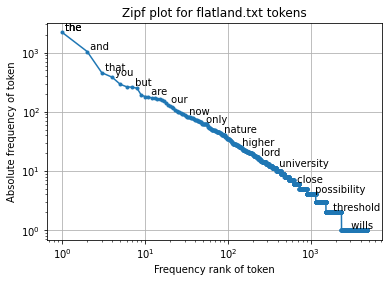

For the full data, we get the following linear regression
slope:     -0.990198    intercept: 8.135727
r_value:   -0.984688    p_value: 0.000000
std_error: 0.002549


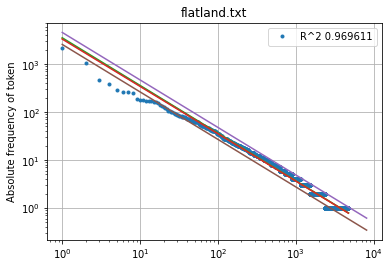

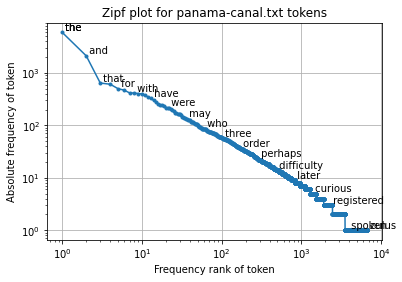

For the full data, we get the following linear regression
slope:     -1.069893    intercept: 9.200944
r_value:   -0.984859    p_value: 0.000000
std_error: 0.002320


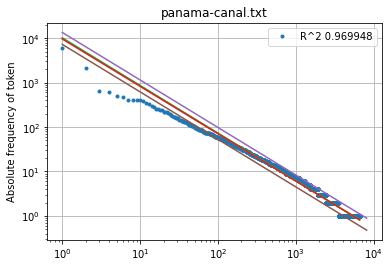

In [41]:
# tokens_dict = {}
# ranks_dict = {}
# freqs_dict = {}

def results():
    for b in books:
        # Tokenize and count frequencies
        tokens_w_count = Counter(map(str.lower, books[b]))

        tokens = sorted([k for k in tokens_w_count.keys()])
        counts = np.array([tokens_w_count[k] for k in tokens])

        ranks = np.arange(1, len(counts) + 1)
        indices = np.argsort(-counts)
        freqs = counts[indices]

        # Plot
        loglog(ranks, freqs, marker=".")
        title("Zipf plot for " + b + " tokens")
        xlabel("Frequency rank of token")
        ylabel("Absolute frequency of token")
        grid(True)
        for n in list(logspace(-0.5, log10(len(counts)), 20).astype(int)):
            # Not all words fit on x-axis; using try-except to break out of loop
            try:
                dummy = text(ranks[n], freqs[n], " " + tokens[indices[n]], 
                             verticalalignment = "bottom", horizontalalignment = "left")
            except IndexError:
                break
        show()
    
        # Fit regression
        fitted_val, lower_fit, upper_fit, upper_pred, lower_pred, r_sq, new_r = linreg(ranks, freqs, 0.95)
        zipf_plot(b, ranks, new_r, freqs, fitted_val, upper_fit, lower_fit, upper_pred, lower_pred, r_sq)

results()

#### Fit Zipf distribution

In [ ]:
# alpha = 1.37065874
# total = sum([p for p, c in lst])
# plt.plot(range(len(lst)), [sts.zipf.pmf(p, alpha) * total for p in range(1, len(lst) + 1)], color='crimson', lw=3)
# plt.ylabel("Population")
# plt.xticks(rotation='vertical')
# plt.tight_layout()
# plt.show()

### Task 6.

We would like to fit the power-law with exponential cutoff instead of standard zipf distribution. Repeat 2) and 3) and compare the fitting of the Zipf law to that of power-law with exponential cutoff for each of the two ebooks.